In [1]:
!pip install streamlit==1.45.1 \
    faster_whisper==1.1.1 \
    feedparser==6.0.11 \
    langchain==0.3.25 \
    langchain-community==0.3.24 \
    langchain-core==0.3.63 \
    langchain-groq==0.3.2 \
    torch==2.7.0 \
    huggingface-hub==0.32.4

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of langchain-text-splitters to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 69.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.5/438.5 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.1/512.1 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 94.

In [9]:
# ============================
# IMPORTS + PROMPTS + MODELS
# ============================

import os
import json
import json5
import re
import subprocess
from typing import List, Optional

from faster_whisper import WhisperModel
from pydantic import BaseModel
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import (
    JsonOutputParser,
    PydanticOutputParser,
    StrOutputParser
)

# ---------- PROMPTS ----------

SUMMARIZATION_PROMPT = """
Generate a 3-part JSON summary:
- core_topic_context
- main_points_arguments
- conclusions_takeaways

Transcript:
{transcript}
"""

GUEST_PROMPT = """
Extract guest speakers who actually speak in the transcript.
Output format:
{{"guests":[{{"name": "...", "title": "..."}}]}}

Transcript:
{transcript}
"""

HIGHLIGHT_PROMPT = """
Extract up to 10 key insights from the transcript.
Each insight MUST include:
- insight_text
- speaker
- timestamp (if unknown leave "")

Return ONLY valid JSON.

FORMAT:
{{
  "insights": [
    {{
      "insight_text": "...",
      "speaker": "...",
      "timestamp": ""
    }}
  ]
}}

Transcript:
{transcript}
"""


# ---------- MODELS ----------

class SummarizationOutput(BaseModel):
    core_topic_context: str
    main_points_arguments: str
    conclusions_takeaways: str

class Guest(BaseModel):
    name: str
    title: Optional[str]

class GuestList(BaseModel):
    guests: List[Guest]

class HighlightItem(BaseModel):
    insight_text: str
    speaker: str
    timestamp: str

class HighlightResult(BaseModel):
    insights: List[HighlightItem]

# ============================
# MODEL LOADERS + HELPERS
# ============================

def load_whisper():
    return WhisperModel("large-v3", device="cuda", compute_type="int8")

def load_llm():
    return ChatGroq(
        model="llama-3.1-8b-instant",
        temperature=0.0,
        max_retries=2,
        groq_api_key="Groq Api Key"   # ADD YOUR KEY HERE
    )


def preprocess_audio(input_path, output_path="processed_audio.wav"):
    command = [
        "ffmpeg",
        "-i", input_path,
        "-ac", "1",      # mono
        "-ar", "16000",  # 16 kHz
        output_path,
        "-y"
    ]
    subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    return output_path


def chunk_text(text, max_tokens=3000):
    words = text.split()
    chunks = []
    current = []
    for w in words:
        current.append(w)
        if len(current) >= max_tokens:
            chunks.append(" ".join(current))
            current = []
    if current:
        chunks.append(" ".join(current))
    return chunks

# ============================
# TRANSCRIPTION WITH TIMESTAMPS
# ============================

def transcribe_audio(audio_path):
    model = load_whisper()

    print("\n Counting segments...")
    total_segments = 0
    for seg in model.transcribe(audio_path, beam_size=1, vad_filter=True)[0]:
        total_segments += 1

    print(f"Total segments: {total_segments}")
    print("\n Transcribing with progress...")

    segments = []

    for i, seg in enumerate(model.transcribe(audio_path, beam_size=3, vad_filter=True)[0]):
        segments.append({
            "text": seg.text,
            "start": seg.start,
            "end": seg.end
        })

        progress = (i + 1) / total_segments * 100
        print(f"Progress: {progress:.2f}% → {seg.start:.2f}s - {seg.end:.2f}s")

    print("\n Transcription completed!\n")

    transcript = " ".join(s["text"] for s in segments)
    return transcript, segments

# ============================
# SUMMARIZATION
# ============================

def run_summarization(llm, transcript):
    prompt = ChatPromptTemplate.from_messages([("system", SUMMARIZATION_PROMPT)])
    parser = JsonOutputParser(pydantic_object=SummarizationOutput)
    chain = prompt | llm | parser

    chunks = chunk_text(transcript, max_tokens=2000)
    partial = []

    for idx, ch in enumerate(chunks):
        print(f"Summarizing chunk {idx+1}/{len(chunks)}...")
        res = chain.invoke({"transcript": ch})
        partial.append(res if isinstance(res, dict) else res.model_dump())

    final_prompt = f"Combine these partial summaries:\n{partial}"
    final_res = chain.invoke({"transcript": final_prompt})

    return final_res if isinstance(final_res, dict) else final_res.model_dump()

# ============================
# GUEST EXTRACTION
# ============================

def run_guests(llm, transcript, chunk_size=4000):
    words = transcript.split()
    chunks = [" ".join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]

    merged = {}

    for chunk in chunks:
        prompt = ChatPromptTemplate.from_messages([("system", GUEST_PROMPT)])
        parser = PydanticOutputParser(pydantic_object=GuestList)
        chain = prompt | llm | parser

        result = chain.invoke({"transcript": chunk})
        if isinstance(result, dict):
            result = GuestList(**result)

        for guest in result.guests:
            key = guest.name.lower().strip()
            if key not in merged or (not merged[key].title and guest.title):
                merged[key] = guest

    return GuestList(guests=list(merged.values()))

# ============================
# HIGHLIGHTS + TIMESTAMP MATCHING
# ============================

def normalize_text(t):
    t = t.lower()
    t = re.sub(r"[^a-z0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def short_key(t, n=12):
    words = normalize_text(t).split()
    return " ".join(words[:n])

def safe_json_parse(raw):
    try:
        return json5.loads(raw)
    except:
        try:
            fixed = raw.rsplit("}", 1)[0] + "}"
            return json5.loads(fixed)
        except:
            return None

from difflib import SequenceMatcher
def format_hhmmss(seconds):
    seconds = int(float(seconds))
    hrs = seconds // 3600
    mins = (seconds % 3600) // 60
    secs = seconds % 60
    return f"{hrs:02d}:{mins:02d}:{secs:02d}"

def find_timestamp_for_text(insight_text, segments, threshold=0.55):
    cleaned = insight_text.lower().strip()

    best_score = 0
    best_start = None

    for seg in segments:
        seg_text = seg["text"].lower()
        score = SequenceMatcher(None, cleaned, seg_text).ratio()

        if score > best_score:
            best_score = score
            best_start = seg["start"]

    # If similarity strong enough, use formatted timestamp
    if best_score >= threshold and best_start is not None:
        return format_hhmmss(best_start)

    return ""


def run_highlights(llm, transcript, segments, chunk_size=4000, max_retries=3):
    words = transcript.split()
    chunks = [" ".join(words[i:i + chunk_size]) for i in range(0, len(words), chunk_size)]

    all_items = []

    for idx, chunk in enumerate(chunks):
        print(f"\n🔹 Processing highlight chunk {idx+1}/{len(chunks)}...")

        prompt = ChatPromptTemplate.from_messages([("system", HIGHLIGHT_PROMPT)])
        chain = prompt | llm | StrOutputParser()

        parsed = None

        for attempt in range(max_retries):
            try:
                raw = chain.invoke({"transcript": chunk})
            except Exception as e:
                print(f"LLM error: {e}")
                continue

            cleaned = (
                raw.replace("```json", "")
                   .replace("```", "")
                   .replace("<json>", "")
                   .replace("</json>", "")
                   .strip()
            )

            parsed = safe_json_parse(cleaned)
            if parsed:
                break

        if parsed is None:
            print("Skipping chunk — JSON failed.")
            continue

        try:
            result = HighlightResult(**parsed)
        except:
            continue

        # Add timestamps
        for item in result.insights:
            item.timestamp = find_timestamp_for_text(item.insight_text, segments)

        # Local dedupe
        local_seen = set()
        cleaned_items = []
        for item in result.insights:
            k = short_key(item.insight_text)
            if k not in local_seen:
                local_seen.add(k)
                cleaned_items.append(item)

        all_items.extend(cleaned_items)

    # Global dedupe
    global_seen = set()
    final_items = []
    for item in all_items:
        k = short_key(item.insight_text)
        if k not in global_seen:
            global_seen.add(k)
            final_items.append(item)

    return HighlightResult(insights=final_items)


In [3]:
# Install dependencies
!pip install tensorflow-text tensorflow rouge-score


from huggingface_hub import InferenceClient
from rouge_score import rouge_scorer
import numpy as np
from numpy import dot
from numpy.linalg import norm

import tensorflow_hub as hub
import tensorflow_text
import numpy as np

use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


def get_embedding(text):
    emb = use_model([text]).numpy()[0]
    emb = emb / (np.linalg.norm(emb) + 1e-9)  # normalize
    return emb

def cosine_sim(a, b):
    return float(np.dot(a, b))

# --- normalize summary fields ---
def normalize_summary_field(field):
    if isinstance(field, str):
        return field
    if isinstance(field, dict):
        return " ".join([normalize_summary_field(v) for v in field.values()])
    if isinstance(field, list):
        return " ".join([normalize_summary_field(v) for v in field])
    return str(field)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 7.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 46.0.3 which is incompatible.
pydrive2 1.

2025-11-19 14:30:03.805825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763562604.038162      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763562604.105905      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1763562633.997217      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763562633.998024      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

In [4]:
def insight_semantic_similarity(highlights, segments):
    scores = []

    for item in highlights.insights:
        insight_emb = get_embedding(item.insight_text)

        best_sim = 0
        for seg in segments:
            seg_emb = get_embedding(seg["text"])
            sim = cosine_sim(insight_emb, seg_emb)
            best_sim = max(best_sim, sim)

        scores.append(best_sim)

    return float(np.mean(scores))



def summary_rouge(summary, transcript):
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
    result = scorer.score(summary["main_points_arguments"], transcript)
    return {
        "rouge1": result["rouge1"].fmeasure,
        "rouge2": result["rouge2"].fmeasure,
        "rougeL": result["rougeL"].fmeasure,
    }


def timestamp_f1(highlights, segments):
    correct = 0
    total = len(highlights.insights)

    for item in highlights.insights:
        if item.timestamp == "":
            continue

        hh, mm, ss = item.timestamp.split(":")
        ts_sec = int(hh) * 3600 + int(mm) * 60 + int(ss)

        for seg in segments:
            if abs(seg["start"] - ts_sec) <= 3:
                correct += 1
                break

    return correct / total if total > 0 else 0


def llm_grade(llm, summary, transcript):
    prompt = f"""
Evaluate this summary on:

- Faithfulness (0-10)
- Coverage (0-10)
- Specificity (0-10)

Transcript:
{transcript}

Summary:
{summary}

Return JSON:
{{"faithfulness":0, "coverage":0, "specificity":0}}
"""
    return llm.invoke({"transcript": prompt})


In [10]:
if __name__ == "__main__":
    raw_audio = "Add Podcast audio"

    print("🎧 Preprocessing audio...")
    processed_audio = preprocess_audio(raw_audio)

    print("🔊 Transcribing...")
    transcript, segments = transcribe_audio(processed_audio)

    llm = load_llm()

    print("\n📘 Summarizing...")
    summary = run_summarization(llm, transcript)
    print(json.dumps(summary, indent=4))

    print("\n🎤 Detecting guests...")
    guests = run_guests(llm, transcript)
    print(json.dumps(guests.model_dump(), indent=4))

    print("\n⭐ Extracting key insights...")
    highlights = run_highlights(llm, transcript, segments=segments)
    print(json.dumps(highlights.model_dump(), indent=4))


🎧 Preprocessing audio...
🔊 Transcribing...

 Counting segments...
Total segments: 243

 Transcribing with progress...
Progress: 0.41% → 0.00s - 3.00s
Progress: 0.82% → 3.00s - 4.00s
Progress: 1.23% → 4.00s - 6.00s
Progress: 1.65% → 6.00s - 10.00s
Progress: 2.06% → 11.00s - 17.25s
Progress: 2.47% → 17.25s - 20.25s
Progress: 2.88% → 20.25s - 25.25s
Progress: 3.29% → 25.25s - 27.25s
Progress: 3.70% → 27.25s - 29.25s
Progress: 4.12% → 29.25s - 32.25s
Progress: 4.53% → 32.25s - 34.25s
Progress: 4.94% → 34.25s - 37.25s
Progress: 5.35% → 37.25s - 40.25s
Progress: 5.76% → 40.25s - 41.25s
Progress: 6.17% → 41.25s - 44.25s
Progress: 6.58% → 44.25s - 50.67s
Progress: 7.00% → 50.67s - 51.67s
Progress: 7.41% → 51.67s - 52.67s
Progress: 7.82% → 52.67s - 55.67s
Progress: 8.23% → 55.67s - 58.67s
Progress: 8.64% → 58.67s - 59.67s
Progress: 9.05% → 59.67s - 60.67s
Progress: 9.47% → 60.67s - 62.67s
Progress: 9.88% → 62.67s - 64.67s
Progress: 10.29% → 64.67s - 67.67s
Progress: 10.70% → 67.67s - 69.67s
Pro

🔍 Evaluating advanced metrics...

📊 Model Performance Metrics:
Semantic Similarity Score: 0.859
Timestamp F1 Score:       1.000
ROUGE Scores:
  ROUGE-1: 0.126
  ROUGE-2: 0.030
  ROUGE-L: 0.057


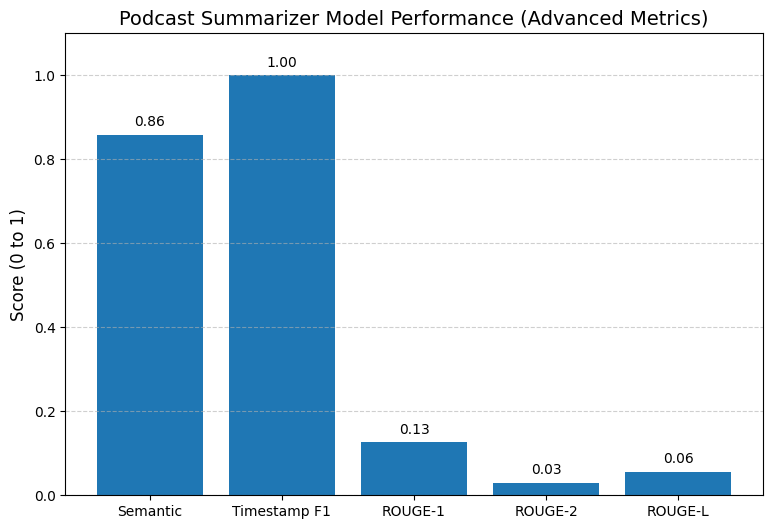

In [11]:
import matplotlib.pyplot as plt

print("🔍 Evaluating advanced metrics...")

# --- compute all metrics ---
sim_score = insight_semantic_similarity(highlights, segments)
# --- run rouge on normalized text ---
summary_normalized = {
    "core_topic_context": normalize_summary_field(summary["core_topic_context"]),
    "main_points_arguments": normalize_summary_field(summary["main_points_arguments"]),
    "conclusions_takeaways": normalize_summary_field(summary["conclusions_takeaways"])
}
rouge = summary_rouge(summary_normalized, transcript)
f1_ts = timestamp_f1(highlights, segments)

# print detailed results
print("\n📊 Model Performance Metrics:")
print(f"Semantic Similarity Score: {sim_score:.3f}")
print(f"Timestamp F1 Score:       {f1_ts:.3f}")
print("ROUGE Scores:")
print(f"  ROUGE-1: {rouge['rouge1']:.3f}")
print(f"  ROUGE-2: {rouge['rouge2']:.3f}")
print(f"  ROUGE-L: {rouge['rougeL']:.3f}")

# --- Visualization ---
labels = ["Semantic", "Timestamp F1", "ROUGE-1", "ROUGE-2", "ROUGE-L"]
values = [sim_score, f1_ts, rouge["rouge1"], rouge["rouge2"], rouge["rougeL"]]

plt.figure(figsize=(9,6))
bars = plt.bar(labels, values)

# add values on top of each bar
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(i, yval + 0.02, f"{yval:.2f}", ha='center', fontsize=10)

plt.ylim(0, 1.1)
plt.title("Podcast Summarizer Model Performance (Advanced Metrics)", fontsize=14)
plt.ylabel("Score (0 to 1)", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
